In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt



In [38]:
data_df = pd.read_csv('network_and_patching_compare_inference_and_count.csv', index_col=0)
data_df['n.bact']=data_df['FP']+data_df['TP']
data_df=data_df.loc[(data_df['mask_type']=='hann') & (data_df['patch_type']=='patch_AB')
           & (data_df['threshold']==0.9)]
data_df = data_df.drop(columns=['mask_type', 'patch_type', 'dice_coefficient', 'IOU', 'threshold'])
data_df

,file,frame,dataset,network,GT,TP,FP,FN,average_precision,recall,precision,F1-score,n.bact
913,BT0403_229.tif,0,validation,Unet,80,62,23,18,0.601942,0.775000,0.729412,0.751515,85
914,BT0403_229.tif,1,validation,Unet,75,62,29,13,0.596154,0.826667,0.681319,0.746988,91
915,BT0403_229.tif,2,validation,Unet,77,66,25,11,0.647059,0.857143,0.725275,0.785714,91
916,BT0403_229.tif,3,validation,Unet,78,66,21,12,0.666667,0.846154,0.758621,0.800000,87
917,BT0403_229.tif,4,validation,Unet,82,68,31,14,0.601770,0.829268,0.686869,0.751381,99
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18193,OGM3.tif,19,validation,BactUnet V3,28,24,12,4,0.600000,0.857143,0.666667,0.750000,36
18194,OGM3.tif,20,validation,BactUnet V3,30,25,12,5,0.595238,0.833333,0.675676,0.746269,37
18195,OGM3.tif,21,validation,BactUnet V3,18,19,9,-1,0.703704,1.055556,0.678571,0.826087,28
18196,OGM3.tif,22,validation,BactUnet V3,25,19,10,6,0.542857,0.760000,0.655172,0.703704,29


In [23]:
val_dir = r"C:\Users\Jens\Documents\Code\BactUnet\_results\network_compare\validation"
train_dir = r"C:\Users\Jens\Documents\Code\BactUnet\_results\network_compare\training"

def read_data(path, label):
    out = pd.DataFrame()
    #out_count = pd.DataFrame()
    with os.scandir(path) as it:
        for entry in it:
            if entry.name.endswith('TP.csv'):
                name = entry.name.split("_")
                fname = name[0]+"_"+name[1]
                network = name[2]
                
                tp_df = pd.read_csv(entry.path)
                gt_df = pd.read_csv(path+"\\"+fname+"_GT_count.csv")
                count_df = pd.read_csv(path+"\\"+fname+"_"+network+"_count.csv")
                frames = np.array(count_df.index)
                count_df['frame'] =  frames
                count_df['file'] = fname+'.tif'
                count_df['network'] = network
                count_df['dataset'] = label
                
                count_df["TP"] = tp_df["Count"]
                count_df["GT"] = gt_df["Count"]
                count_df["FP"] = count_df["Count"] - count_df["TP"]
                count_df["FN"] = count_df["GT"] - count_df["TP"]
                count_df['precision'] = count_df['TP']/(count_df['TP']+count_df['FP'])
                count_df['recall'] = count_df['TP']/(count_df['TP']+count_df['FN'])
                count_df['average_precision'] = count_df['TP']/(count_df['TP']+count_df['FP']+count_df['FN'])
                count_df['F1-score'] = (2*count_df['recall']*count_df['precision'])/(count_df['recall']+count_df['precision'])
                count_df['n.bact'] = count_df["Count"]
                
                out = pd.concat([out, count_df], ignore_index=True)
        return out 

cp_df = pd.concat([read_data(val_dir, "validation"), read_data(train_dir, "training")], ignore_index=True)
cp2 = cp_df.drop(columns=['Slice', 'Count', 'Total Area', 'Average Size', '%Area', 'Mean'])
cp2 = cp2.loc[(cp2['network']=='CP2')]
cp2.head()


,frame,file,network,dataset,TP,GT,FP,FN,precision,recall,average_precision,F1-score,n.bact
0,0,BT0407_110.tif,CP2,validation,16,25,19,9,0.457143,0.640000,0.363636,0.533333,35
1,1,BT0407_110.tif,CP2,validation,17,28,18,11,0.485714,0.607143,0.369565,0.539683,35
2,2,BT0407_110.tif,CP2,validation,18,36,7,18,0.720000,0.500000,0.418605,0.590164,25
3,3,BT0407_110.tif,CP2,validation,19,37,5,18,0.791667,0.513514,0.452381,0.622951,24
4,4,BT0407_110.tif,CP2,validation,20,41,9,21,0.689655,0.487805,0.400000,0.571429,29


In [52]:
data_dir = r"C:\Users\Jens\Documents\Code\BactUnet\_results\mcherry_compare"

dataset_dict = {
    'BT0403_229.tif':'validation',
    'BT0407_110.tif':'validation',
    'BT353_001.tif':'validation',
    'BT0398_210.tif':'training',
    'BT402_169.tif':'training',
    'BT403_002.tif':'training',
    'BT404_199.tif':'training',
    'OGM3.tif':'validation'
    }


def read_mcherry_data(path):
    out = pd.DataFrame()
    #out_count = pd.DataFrame()
    with os.scandir(path) as it:
        for entry in it:
            if entry.name.endswith('TPs.csv'):
                name = entry.name.split("_")
                fname = name[0]+"_"+name[1]
                network = name[2]
                tp_df = pd.read_csv(entry.path)
                gt_df = pd.read_csv(path+"\\"+fname+"_"+network+"_counts.csv")
                count_df = pd.read_csv(path+"\\"+fname+"_"+network+"_auto.csv")
                dic_df = pd.read_csv(path+"\\"+fname+"_DIC_count.csv")
                frames = np.array(count_df.index)
                count_df['frame'] =  frames
                count_df['file'] = fname+'.tif'
                count_df['network'] = network
                #count_df['dataset'] = dataset_dict[fname+'.tif']
                count_df['dataset'] = 'validation'
                
                count_df["TP"] = tp_df["Count"]
                count_df["GT"] = dic_df["Count"]
                
                count_df["manual_mcherry"] = gt_df["Count"]
                count_df["auto_mcherry"] = count_df["Count"]
                
                count_df["ratio_man_DIC"] = count_df["manual_mcherry"]/count_df["manual_DIC"]
                count_df["ratio_auto_man"] = count_df["auto_mcherry"]/count_df["manual_mcherry"]
                count_df["ratio_auto_DIC"] = count_df["auto_mcherry"]/count_df["manual_DIC"]
                
                out = pd.concat([out, count_df], ignore_index=True)
        return out 
mcherry_data = read_mcherry_data(data_dir)

mcherry_data


,Slice,Count,Total Area,Average Size,%Area,Mean,frame,file,network,dataset,TP,manual_mcherry,auto_mcherry,manual_DIC,ratio_man_DIC,ratio_auto_man,ratio_auto_DIC
0,c:2/2 t:210/240 - anodisc_OGM_1_MMStack_Default,121,801.502,6.624,0.541,255,0,BT0398_210.tif,mcherry,validation,117,155,121,162,0.956790,0.780645,0.746914
1,c:2/2 t:211/240 - anodisc_OGM_1_MMStack_Default,122,841.356,6.896,0.568,255,1,BT0398_210.tif,mcherry,validation,119,155,122,166,0.933735,0.787097,0.734940
2,c:2/2 t:212/240 - anodisc_OGM_1_MMStack_Default,112,723.525,6.460,0.489,255,2,BT0398_210.tif,mcherry,validation,108,152,112,162,0.938272,0.736842,0.691358
3,c:2/2 t:213/240 - anodisc_OGM_1_MMStack_Default,114,789.315,6.924,0.533,255,3,BT0398_210.tif,mcherry,validation,112,156,114,167,0.934132,0.730769,0.682635
4,c:2/2 t:214/240 - anodisc_OGM_1_MMStack_Default,117,778.689,6.655,0.526,255,4,BT0398_210.tif,mcherry,validation,114,157,117,165,0.951515,0.745223,0.709091
5,c:2/2 t:215/240 - anodisc_OGM_1_MMStack_Default,115,791.267,6.881,0.534,255,5,BT0398_210.tif,mcherry,validation,111,157,115,167,0.940120,0.732484,0.688623
6,c:2/2 t:216/240 - anodisc_OGM_1_MMStack_Default,118,850.392,7.207,0.574,255,6,BT0398_210.tif,mcherry,validation,115,152,118,152,1.000000,0.776316,0.776316
7,c:2/2 t:217/240 - anodisc_OGM_1_MMStack_Default,115,825.124,7.175,0.557,255,7,BT0398_210.tif,mcherry,validation,111,151,115,150,1.006667,0.761589,0.766667
8,c:2/2 t:218/240 - anodisc_OGM_1_MMStack_Default,116,912.612,7.867,0.616,255,8,BT0398_210.tif,mcherry,validation,111,145,116,146,0.993151,0.800000,0.794521
9,c:2/2 t:219/240 - anodisc_OGM_1_MMStack_Default,117,831.120,7.104,0.561,255,9,BT0398_210.tif,mcherry,validation,112,150,117,145,1.034483,0.780000,0.806897


In [39]:
alldata = pd.concat((data_df, cp2), ignore_index=True)

alldata

,file,frame,dataset,network,GT,TP,FP,FN,average_precision,recall,precision,F1-score,n.bact
0,BT0403_229.tif,0,validation,Unet,80,62,23,18,0.601942,0.775000,0.729412,0.751515,85
1,BT0403_229.tif,1,validation,Unet,75,62,29,13,0.596154,0.826667,0.681319,0.746988,91
2,BT0403_229.tif,2,validation,Unet,77,66,25,11,0.647059,0.857143,0.725275,0.785714,91
3,BT0403_229.tif,3,validation,Unet,78,66,21,12,0.666667,0.846154,0.758621,0.800000,87
4,BT0403_229.tif,4,validation,Unet,82,68,31,14,0.601770,0.829268,0.686869,0.751381,99
...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,BT403_002.tif,9,training,CP2,93,41,2,52,0.431579,0.440860,0.953488,0.602941,43
284,BT403_002.tif,10,training,CP2,94,40,6,54,0.400000,0.425532,0.869565,0.571429,46
285,BT404_199.tif,0,training,CP2,155,67,4,88,0.421384,0.432258,0.943662,0.592920,71
286,BT404_199.tif,1,training,CP2,155,61,7,94,0.376543,0.393548,0.897059,0.547085,68


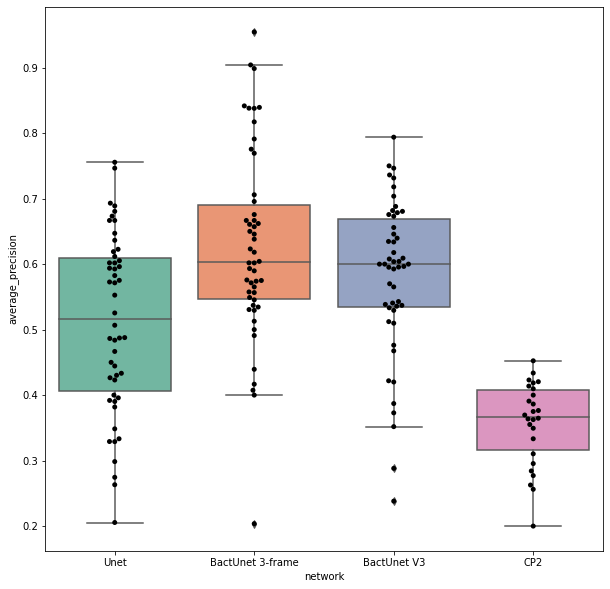

In [62]:
plt.figure(figsize=(10,10))
#sns.set_style('white')
metric = 'average_precision'

g3 = sns.boxplot(data=alldata.loc[(alldata['dataset']=='validation')],
                 x='network', y=metric, palette='Set2')
g3 = sns.swarmplot(data=alldata.loc[alldata['dataset']=='validation'],
                 x='network', y=metric, color='black')


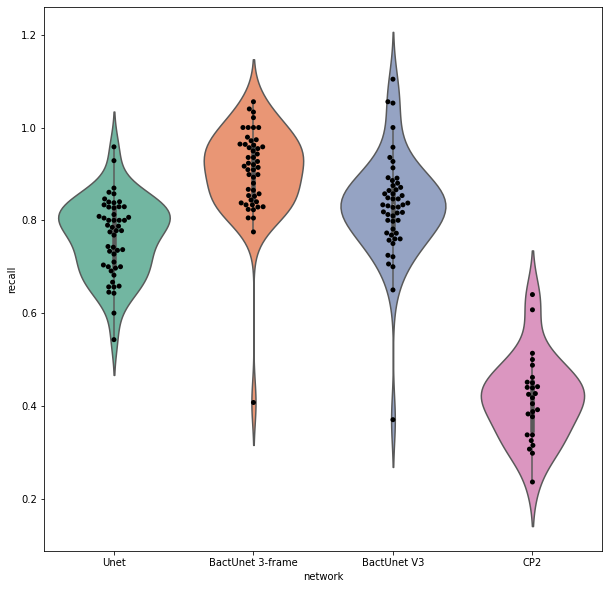

In [44]:
plt.figure(figsize=(10,10))
#sns.set_style('white')
g3 = sns.violinplot(data=alldata.loc[alldata['dataset']=='validation'],
                 x='network', y='recall', palette='Set2')
g3 = sns.swarmplot(data=alldata.loc[alldata['dataset']=='validation'],
                 x='network', y='recall', color='black')